In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input


In [6]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)


In [8]:
def get_feature_extractor():
    vgg = VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_output = vgg.get_layer(content_layer).output
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
    return Model(inputs=vgg.input, outputs=[content_output] + style_outputs)

def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    tensor = tf.reshape(tensor, [-1, channels])
    return tf.matmul(tensor, tensor, transpose_a=True) / tf.cast(tf.shape(tensor)[0], tf.float32)

def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def compute_style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))


In [16]:
content_image = load_and_preprocess_image('/kaggle/input/pictures/content.webp')
style_image = load_and_preprocess_image('/kaggle/input/pictures/style.webp')


In [19]:
from tensorflow.keras.applications import VGG19

# Use the path of the uploaded weights file
local_weights_path = '/kaggle/input/vgg19-weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG19(weights=local_weights_path, include_top=False)
vgg.trainable = False

# Now continue with your feature extraction code as planned


In [22]:
# Define the Gram matrix function for style representation
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    tensor = tf.reshape(tensor, [-1, channels])
    return tf.matmul(tensor, tensor, transpose_a=True) / tf.cast(tf.shape(tensor)[0], tf.float32)

# Content and style loss functions
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def compute_style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))


In [23]:
# Hyperparameters
content_weight = 1e4
style_weight = 1e-2
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Initialize generated image as content image
generated_image = tf.Variable(content_image, dtype=tf.float32)


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Define the feature extractor using VGG19
def get_feature_extractor():
    vgg = VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    output_layers = [vgg.get_layer(name).output for name in [content_layer] + style_layers]
    return Model([vgg.input], output_layers)

# Create the feature extractor instance
feature_extractor = get_feature_extractor()

# Define the train_step function if not already defined
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        generated_features = feature_extractor(generated_image)
        content_loss = compute_content_loss(content_features, generated_features[0])
        style_loss = sum(compute_style_loss(style, gen) for style, gen in zip(style_features, generated_features[1:]))
        total_loss = content_loss + style_loss

    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))
    return total_loss

# Train the model
epochs = 1000
for epoch in range(epochs):
    loss = train_step(generated_image)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [27]:
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        generated_features = feature_extractor(generated_image)
        content_loss = compute_content_loss(content_features, generated_features[0])
        style_loss = sum(compute_style_loss(style, gen) for style, gen in zip(style_features, generated_features[1:]))
        total_loss = content_weight * content_loss + style_weight * style_loss
    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    return total_loss

# Run style transfer
epochs = 1000
for epoch in range(epochs):
    loss = train_step(generated_image)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


NameError: in user code:

    File "/tmp/ipykernel_30/4206781605.py", line 4, in train_step  *
        generated_features = feature_extractor(generated_image)

    NameError: name 'feature_extractor' is not defined


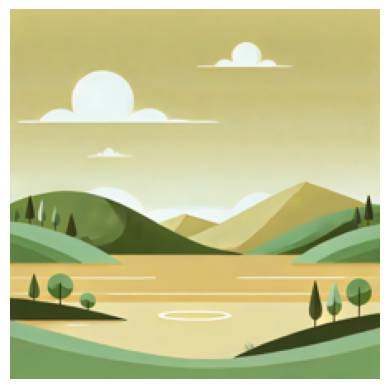

In [25]:
# De-process and display the result
def deprocess_image(img):
    img = img[0]
    img = np.clip(img + [103.939, 116.779, 123.68], 0, 255).astype('uint8')
    return img

# Display the final image
result = deprocess_image(generated_image.numpy())
plt.imshow(result)
plt.axis('off')
plt.show()


In [26]:
output_image = Image.fromarray(result)
output_image.save('/kaggle/working/stylized_image.png')
print("Image saved successfully.")



Image saved successfully.
